In [2]:
from bs4 import BeautifulSoup
import requests
from urllib.parse import urljoin
import re
import pandas as pd
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from keybert import KeyBERT
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Scraping
## Extracción de datos de la web ludopatía.org
Se obtienen páginas de conversaciones del foro "General" de la página.  
De estas conversaciones se almacenan todos los mensajes, con cada usuario, fecha y título de la conversación. Debido a que hay demasiados mensajes, se han limitado a 20 páginas de conversaciones.
## Este scraping se divide en 2 partes
### Parte 1
Se obtienen los enlaces de todas las conversaciones que se van a scrapear.

In [3]:
base_url = 'https://www.ludopatia.org/forum/default.asp'
response = requests.get(base_url)
# Parser HTML
soup = BeautifulSoup(response.content, 'html.parser')
# Se obtiene el apartado del foro General, donde más mensajes hay
forum = soup.find('a', string='General')
general_forum_link = urljoin(base_url, forum.get('href'))
general_forum_html = requests.get(general_forum_link)
soup = BeautifulSoup(general_forum_html.content, 'html.parser')
# Se recorren los links de foro evitando la flecha de siguiente mensaje, tomando todas las conversaciones
forum_types = []
for link in soup.find_all('a'):
    if 'forum' in link.get('href') and link.find('img') is None:
        page_actual = link.get('href')
        page_link = urljoin(base_url, page_actual)
        forum_types.append(page_link)
# Se toma el foro que se desea scrapear
selected_forum = forum_types[0]
forum_content = requests.get(selected_forum)
forumSoup = BeautifulSoup(forum_content.content, 'html.parser')
msg_list = []
next_page = True
# Número de páginas a scrapear
cont = 20
# Se recorren todas las páginas del foro guardando los enlaces a los mensajes
while next_page:
    links = forumSoup.find_all('a')
    links = [link for link in links if 'forum' in link.get('href') and link.find('img') is None]
    
    if 'Siguiente' not in links[len(links)-1].text:
        next_page = False
    
    if cont == 1:
        next_page = False
    else:
        cont = cont -1
    
    for msg in links:
        if 'Anterior' not in msg.text and 'Siguiente' not in msg.text:
            msg_actual = msg.get('href')
            msg_link = urljoin(page_link, msg_actual)
            msg_list.append(msg_link)
            
    next_page_link = urljoin(base_url, links[len(links)-1].get('href'))
    next_page_response = requests.get(next_page_link)
    forumSoup = BeautifulSoup(next_page_response.content, 'html.parser')
    
msg_list = [string for string in msg_list if not string.endswith("TPN=1")]
print('Se han obtenido ', len(msg_list), ' páginas de conversaciones')

Se han obtenido  814  páginas de conversaciones


### Parte 2
Se obtiene la información y se crea el dataframe en pandas con toda la información.  
Si la obtención de información de mensajes da error, simplemente se pasa al siguiente. Se ha tomado esta decisión debido a que la cantidad de mensajes es más que suficiente.

In [4]:
# Creación del dataframe en el que se almacenará la información
df = pd.DataFrame({'user': [], 'date': [], 'title': [], 'text':[]})
# Patrones para encontrar el título de la conversación y la fecha
date_pattern = re.compile('Escrito el:.*[0-9]{2}:[0-9]{2}')
title_pattern = re.compile('Tema:.*')
# Se recorre toda la colección de conversaciones obtenida en la parte anterior
for url in msg_list:
    try:
        msg = requests.get(url)
        forumSoup = BeautifulSoup(msg.content, 'html.parser')
        body = forumSoup.find('body')
        title = title_pattern.search(body.text)[0].split('Tema:')[1].strip()
        forum_messages = body.find_all('table')[5].find_all('table')[0]
        # Obtención de las filas con los mensajes de la conversación
        table_rows = forum_messages.find_all('tr', recursive = False)
        for i in table_rows:
            user_list = i.find_all('span', {'class':'bold'})
            # Toda fila con mensaje, tiene nombre de usuario, por lo que si no se ha encontrado el nombre, no es un mensaje
            if len(user_list) > 0:
                # Obtención de los datos del mensaje
                user = user_list[0].text
                text = i.find_all('td', {'class':'text'})[0].text
                text = text.split('__________________')[0]
                text = text.split('Editado por')[0]
                date = date_pattern.search(text)[0].split(': ')[1]
                text = re.split(date_pattern, text)[1].strip()
                if len(text)>0:
                    new_row = pd.DataFrame({'user': [user], 'date': [date], 'title': [title], 'text': [text]})
                    df = pd.concat([df, new_row], ignore_index=True)
    except Exception as e:
        continue

## Observación del dataset resultado
  
Como se puede observar, en el dataset resultado se han obtenido 8158 mensajes

In [5]:
df

,user,date,title,text
0,administrator,23 de Marzo de 2009 a las 16:10,ASOCIACIONES DE TRATAMIENTO,Parece que hubo algún problema con los criteri...
1,luisafernandez,20 de Enero de 2010 a las 19:03,ASOCIACIONES DE TRATAMIENTO,Hola: en bilbao hay una asociaciÃ³n sin Ã¡nimo...
2,administrator,23 de Enero de 2010 a las 10:10,ASOCIACIONES DE TRATAMIENTO,"Hola Luisa, a ver si nos especializamos en el ..."
3,jasito,12 de Febrero de 2010 a las 18:52,ASOCIACIONES DE TRATAMIENTO,"hola buenas tardes, necesito ayuda urgente y n..."
4,administrator,13 de Febrero de 2010 a las 09:53,ASOCIACIONES DE TRATAMIENTO,"Hola jasito, prueba en diferentes horarios, y ..."
...,...,...,...,...
8154,kiko.,08 de Oc tubre de 2019 a las 05:00,DEUDAS,¿Y?\r Chico lo poco que has escrito aquí \rno ...
8155,kiko.,08 de Oc tubre de 2019 a las 01:40,Para mí amigo,Hubo un momento en mi vida que tenía \rmuchos ...
8156,kiko.,08 de Oc tubre de 2019 a las 01:58,Para mí amigo,", tu ya no te\racuerdas de bloquearte, encima ..."
8157,adicted,08 de Oc tubre de 2019 a las 02:55,Para mí amigo,como siempre digo siempre hay nivel nuevo de d...


## Guardado y carga del dataframe en un archivo .json  
Destacar la importancia de guardar y cargar los datos con la codificación de caracteres correcta.

In [6]:
df.to_json('/home/noel/Documentos/NoEstructurada/corpus.json', orient='split', force_ascii=False)

In [3]:
df = pd.read_json('/home/noel/Documentos/NoEstructurada/corpus.json', orient='split', encoding='utf-8')
df

,user,date,title,text
0,administrator,23 de Marzo de 2009 a las 16:10,ASOCIACIONES DE TRATAMIENTO,Parece que hubo algún problema con los criteri...
1,luisafernandez,20 de Enero de 2010 a las 19:03,ASOCIACIONES DE TRATAMIENTO,Hola: en bilbao hay una asociaciÃ³n sin Ã¡nimo...
2,administrator,23 de Enero de 2010 a las 10:10,ASOCIACIONES DE TRATAMIENTO,"Hola Luisa, a ver si nos especializamos en el ..."
3,jasito,12 de Febrero de 2010 a las 18:52,ASOCIACIONES DE TRATAMIENTO,"hola buenas tardes, necesito ayuda urgente y n..."
4,administrator,13 de Febrero de 2010 a las 09:53,ASOCIACIONES DE TRATAMIENTO,"Hola jasito, prueba en diferentes horarios, y ..."
...,...,...,...,...
8154,kiko.,08 de Oc tubre de 2019 a las 05:00,DEUDAS,¿Y?\r Chico lo poco que has escrito aquí \rno ...
8155,kiko.,08 de Oc tubre de 2019 a las 01:40,Para mí amigo,Hubo un momento en mi vida que tenía \rmuchos ...
8156,kiko.,08 de Oc tubre de 2019 a las 01:58,Para mí amigo,", tu ya no te\racuerdas de bloquearte, encima ..."
8157,adicted,08 de Oc tubre de 2019 a las 02:55,Para mí amigo,como siempre digo siempre hay nivel nuevo de d...


## Aplicación del tf/idf  
El tf/idf es un indicador que permite calcular la importancia de una palabra en una colección de documentos. Utiliza la frecuencia del término en los textos, compensando el valor de cada término con el número de documentos en el que aparece la palabra.  
   
Se calcula el tf/idf de las palabras de todo el corpus eliminando las palabras menores de 4 letras, las que aparezcan en menos de 10 documentos y las stopwords.  
Luego se ordenan las palabras según este valor y se obtienen las 50 primeras.

In [12]:
stop_words=nltk.corpus.stopwords.words('spanish')
vectorizer = TfidfVectorizer(stop_words=stop_words, min_df=10, token_pattern=r'\b[a-zA-ZÁÉÍÓÚáéíóú]{4,}\b')
tfidf = vectorizer.fit_transform(df['text'])
df_tfidf = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names_out())
top_tfidf_words = df_tfidf.sum().sort_values(ascending=False)[:50]
print(top_tfidf_words)

jugar         234.295706
juego         207.112020
foro          185.581617
dinero        151.184322
vida          148.602435
hacer         136.298923
solo          134.932782
aquí          133.745832
creo          133.360136
bien          129.079288
gracias       127.552546
tiempo        125.592370
puede         117.251406
mismo         113.802054
ahora         112.553100
hace          109.794170
siempre       105.648142
cosas         100.890961
problema      100.499199
mejor          96.005301
enfermedad     95.870451
ayuda          95.327054
pues           94.491239
dejar          94.216005
escribió       92.417944
aunque         91.332605
ludopatía      91.315817
abrazo         91.272924
verdad         89.079606
cada           88.474819
menos          86.911745
caso           85.557298
decir          84.953773
gente          84.772794
saludos        83.071972
tener          81.212875
nunca          80.837139
bueno          80.535057
veces          79.449495
medidas        77.665524


## Term Frecuency(TF)  
La frecuencia de un término es el número de veces que aparece en el conjunto de documentos.  
  
Para calcular el tf de los términos de todos los documentos se utiliza un contador de palabras. Se aplican las mismas restricciones que en el caso del tf/idf y se obtienen las 100 palabras que tienen mayor tf ordenadas de mayor a menor.

In [6]:
count_vectorizer = CountVectorizer(stop_words=stop_words, min_df=10, token_pattern=r'\b[a-zA-ZÁÉÍÓÚáéíóú]{4,}\b')
counter = count_vectorizer.fit_transform(df['text'])
bow = pd.DataFrame(counter.toarray(), columns=count_vectorizer.get_feature_names_out())
top_frecuency_words = bow.sum().sort_values(ascending=False)[:100]
for i in range(len(top_frecuency_words)):
    print(i, '   ' ,top_frecuency_words.index[i], ' ', top_frecuency_words[i])

0     jugar   4420
1     juego   4083
2     foro   2886
3     vida   2597
4     dinero   2597
5     hacer   2194
6     solo   2144
7     creo   2046
8     tiempo   1976
9     bien   1958
10     aquí   1932
11     mismo   1801
12     hace   1765
13     puede   1741
14     ahora   1669
15     siempre   1654
16     cosas   1501
17     enfermedad   1475
18     problema   1362
19     aunque   1320
20     ludopatía   1299
21     dejar   1260
22     menos   1251
23     mejor   1249
24     ayuda   1246
25     cada   1228
26     pues   1210
27     caso   1189
28     veces   1175
29     tener   1163
30     nunca   1143
31     decir   1123
32     gracias   1112
33     gente   1096
34     verdad   1094
35     medidas   1042
36     escribió   1039
37     hecho   1028
38     puedo   1009
39     cuenta   956
40     persona   949
41     bueno   910
42     quiero   909
43     cómo   891
44     poder   888
45     nadie   882
46     dicho   881
47     ludopata   874
48     muchas   866
49     momento   8

# KeyBERT  
Se carga el modelo y a través de la función 'extract_keywords' se obtiene conjunto de listas de tuplas (una lista por documento, y una tupla por palabra del documento) con las palabras y sus puntuaciones correspondientes.  
Esta puntuación representa la importancia de la palabra en el texto. 

In [7]:
stop_words=nltk.corpus.stopwords.words('spanish')
model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v1')
model = KeyBERT(model=model)
keywords = model.extract_keywords(df['text'], stop_words=stop_words)

## Acumulación de puntuaciones  
Para poder ordenar las palabras según su importancia, primero se crea un diccionario donde existe una clave por palabra y en el valor de la clave se acumula la puntuación correspondiente a la palabra.

In [8]:
distances_keywords = {}
for sentence in keywords:
    for tuple in sentence:
        if tuple[0] in distances_keywords.keys():
            distances_keywords[tuple[0]] += tuple[1]
        else:
            distances_keywords[tuple[0]] = tuple[1]

Una vez acumuladas las puntuaciones de las palabras, ya se pueden ordenar según su importancia

In [9]:
sorted_words = sorted(distances_keywords.items(), key= lambda x : x[1], reverse = True)
print(sorted_words)

[('juego', 253.9495000000002), ('jugar', 246.3879), ('foro', 95.68970000000002), ('rehabilitación', 88.99799999999996), ('enfermedad', 83.52539999999999), ('dinero', 72.76250000000002), ('ludopatía', 66.36810000000003), ('ludopatia', 65.1349), ('gracias', 64.73559999999999), ('escribió', 61.972999999999956), ('adicción', 54.76440000000002), ('ayuda', 54.37069999999999), ('apuestas', 51.902200000000015), ('deudas', 46.38750000000001), ('paco', 46.10759999999999), ('jugando', 41.328800000000015), ('kiko', 40.425999999999995), ('asociación', 38.85139999999998), ('casino', 37.55070000000003), ('adicto', 31.099300000000017), ('casinos', 30.81899999999999), ('terapia', 29.5831), ('abrazo', 29.256099999999996), ('disculpas', 28.707799999999988), ('adicciones', 28.157500000000002), ('ludopata', 27.362799999999993), ('medidas', 26.7317), ('alfonso', 26.363299999999988), ('psicólogo', 25.84699999999999), ('deuda', 25.089400000000005), ('rehabilitado', 24.775300000000012), ('saludos', 23.7533), (

# Creación de la nube de palabras

En este caso, la nube de palabras se crea a partir de los términos y las puntuaciones extraídas del apartado anterior, utilizando el modelo de Keybert.  
  
Se utiliza el método 'generate_from_frequencies' para que las palabras tengan tamaño proporcional a la puntuación correspondiente obtenida.

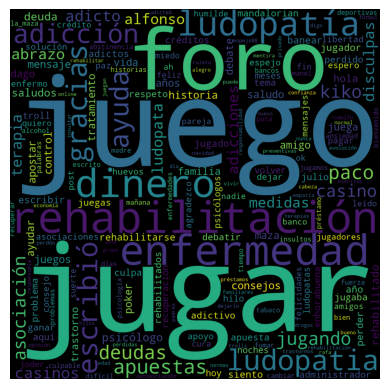

In [10]:
wordcloud = WordCloud(width=1200, height=1200, background_color='black', min_font_size=10)
wordcloud.generate_from_frequencies(distances_keywords)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()